# Diseño de etapa de extracción de características de perfil de adhesivo

Autor: Alfredo Rodríguez Magdalena

Normagrup Technology (c) Copyright

El objetivo de este cuaderno Jupyter será diseñar una función que sea capaz de extraer las características estáticas del perfil de adhesivo depositado en la pista de la bandeja.

La función [perfilProc, Q, tr, posHilo] = procesarPerfil(perfil) procesa el perfil de deposición medido por el perfilómetro OXP-200 siguiendo los siguientes pasos:
1. Acondicionar y filtra la señal.
2. Emplear un algoritmo heurístico para identificar la pista y el hilo de adhesivo.
3. Llevar a cabo una SVD para trabajar con el perfil en una base adecuada.
4. Calcular las características

In [1]:
## Librerías necesarias para el correcto funcionamiento del programa

# Librerías para el manejo de datos
import pandas as pd

# Librerías para computación científica
import numpy as np 
from scipy.signal import filtfilt, argrelextrema
from scipy.integrate import trapz
#from sklearn.decomposition import PCA

# Gráficos y visualización
import matplotlib.pyplot as plt
%matplotlib inline

<center><img src="../docs/FigurasJupyter/esquemaAnexoIV.png" width="1000px"/></center>

## Paso 0. Obtención de perfil

Como paso previo a todo el programa, se deberá obtener la información de un perfil medido por el sensor.

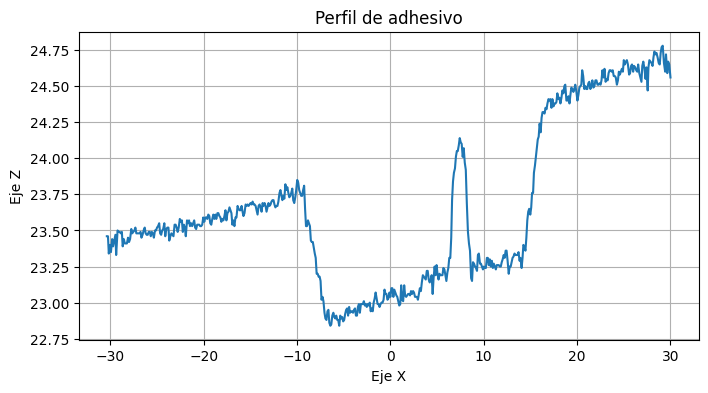

In [4]:
# Obtención de los datos
path = r"../datos/muestraPerfil.csv" # Perfil escogido al azar

# Lectura de los datos
data = pd.read_csv(path)

# Formateo de los datos
xRaw = data["Eje X"].to_numpy(dtype = np.float64)
zRaw = data["Eje Z"].to_numpy(dtype = np.float64)

# Volteo de los datos
xRaw = np.flipud(xRaw)
zRaw = np.flipud(zRaw)

# Visualización de los datos
plt.figure(figsize = (8, 4))
plt.plot(xRaw, zRaw)
plt.title("Perfil de adhesivo")
plt.xlabel("Eje X")
plt.ylabel("Eje Z")
plt.grid(True)
plt.show()

## Paso 1. Acondicionamiento y filtrado de la señal

En un primer lugar, se eliminarán offsets en ambas componentes de las nubes de puntos para poder tratar correctamente la información.

$$\vec{x}=\begin{bmatrix}
x_1-\bar{x} \\
x_2-\bar{x} \\
\vdots \\
x_n-\bar{x}
\end{bmatrix}$$

$$\vec{z}=\begin{bmatrix}
z_1-\min{z} \\
z_2-\min{z} \\
\vdots \\
z_n-\min{z}
\end{bmatrix}$$

In [5]:
# Acondicionamiento de los datos
xRaw = xRaw - np.mean(xRaw)
zRaw = zRaw - np.min(zRaw)

A continuación, se procederá a hacer un filtro basado en una media móvil con ventanas de trabajo de 5 elementos.

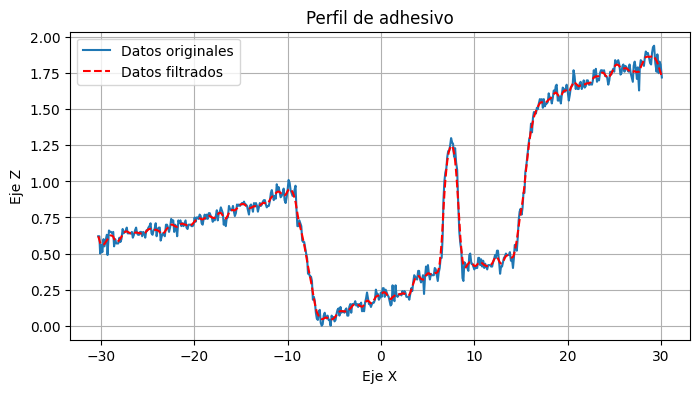

In [6]:
# Coeficientes del filtro
b = np.array([1, 1, 1, 1, 1]) / 5.0
a = 1

# Uso de filtro de fase 0 sobre los datos en el eje Z
zFilt = filtfilt(b, a, zRaw)
coords = np.column_stack((xRaw,zFilt))

# Visualización de los datos
plt.figure(figsize = (8, 4))
plt.plot(xRaw, zRaw)
plt.plot(xRaw, zFilt, 'r--')
plt.title("Perfil de adhesivo")
plt.xlabel("Eje X")
plt.ylabel("Eje Z")
plt.grid(True)
plt.legend(["Datos originales", "Datos filtrados"])
plt.show()

## Paso 2. Detección de hilo mediante derivación numérica

Para detectar el hilo es necesario analizar la derivada de la señal. Para eso se deberán emplear métodos de derivación numérica, pero se debe tener en cuenta que los datos del eje z no están equispaciados sobre el eje x. Por ello, habrá que recurrir a otros tipos de teoremas, que no son los convencionales.

Una forma de lidiar con esta situación es usando un polinomio de interpolación de Lagrange para cada conjunto de tres puntos adyacentes, y una vez obtenido, derivarlo. Dicha expresión sería de la siguiente forma:

$$\frac{\partial}{\partial x}f(x) \approx f(x_{i-1})\frac{2x-x_i-x_{i+1}}{(x_{i-1}-x_i)(x_{i-1}-x_{i+1})}+f(x_i)\frac{2x-x_{i-1}-x_{i+1}}{(x_i-x_{i-1})(x_i-x_{i+1})}+f(x_{i+1})\frac{2x-x_i-x_{i-1}}{(x_{i+1}-x_i)(x_{i+1}-x_{i-1})}$$

In [7]:
def uneqDiff(x : np.array, z : np.array) -> np.array:
    """
    Función que calcula la derivada no equiespaciada entre dos vectores.
    """
    # Creación de array vacío para almacenar las derivadas
    zDif = np.array([0]*(len(z)-1), dtype = np.float64) # Importante el tipo float 64 porque si no el programa trunca los valores

    # Cálculo de la diferencia no equiespaciada
    for i in range(len(z)-3):
        aux1 = z[i] * (x[i+1]-x[i+2])/((x[i]-x[i+1])*(x[i]-x[i+2]))
        aux2 = z[i+1] * (2*x[i+1]-x[i]-x[i+2])/((x[i+1]-x[i])*(x[i+1]-x[i+2]))
        aux3 = z[i+2] * (x[i+1]-x[i])/((x[i+2]-x[i])*(x[i+2]-x[i+1]))
        zDif[i] = aux1 + aux2 + aux3

    return zDif

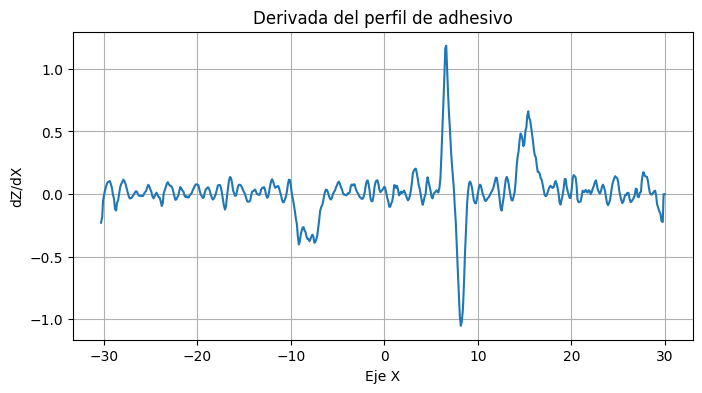

In [8]:
# Derivación numérica de datos no equiespaciados sobre el eje X
zDif = uneqDiff(coords[:, 0], coords[:, 1])
# Uso de filtro sobre la derivada
#zDif = filtfilt(b, a, zDif)
#zDif = medfilt(zDif, 5)

# Concatenación de los datos
diffCoords = np.column_stack((coords[:-1, 0], zDif))

plt.figure(figsize = (8, 4))
plt.plot(coords[:-1, 0], zDif)
plt.title("Derivada del perfil de adhesivo")
plt.xlabel("Eje X")
plt.ylabel("dZ/dX")
plt.grid(True)

A pesar de que la derivada de la señal tenga implementado el mismo filtro que la propia señal, se puede apreciar la existencia de un armónico que perjudica mucho el trabajo de búsqueda de máximos y mínimos. Por ello, se hará un filtrado espectral empleando la FFT.

Este algoritmo es muy relevante en la ingeniería, y es una versión de la _Transformada Discreta de Fourier_, el cual descompone una señal periódica en una suma de senoides discretas. La transformada directa se puede definir como:

$$Y_n = \sum^{N-1}_{k=0}{y_ke^{-jn\theta_0k}} \Longleftrightarrow y_k=\frac{1}{N}\sum^{N-1}_{n=0}{Y_ne^{jn\theta_0k}}$$

Donde N es el número de muestras en un periodo y $\theta_0=2\pi/N$ es la frecuencia fundamental normalizada. 

Debido a la gran eficiencia de la FFT sobre la DFT, su aplicación se ha generalizado a cualquier tipo de tareas de análisis de armónicos, e incluso se puede usar para lidiar con señales que ni siquiera son periódicas. Cabe mencionar que la señal que se está tratando no es periódica, pero el objetivo no es descomponerla en senoides, lo que se pretende es eliminar armónicos para reducir el ruido. De esta forma se puede facilitar la tarea de los algoritmos de búsqueda de extremos relativos, ya que con este filtro se verá la misma señal "suavizada".

563


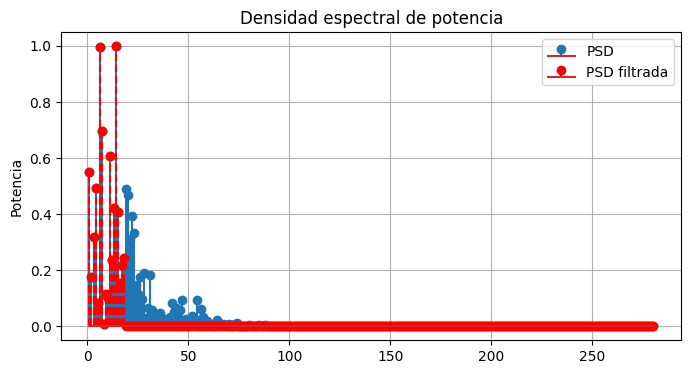

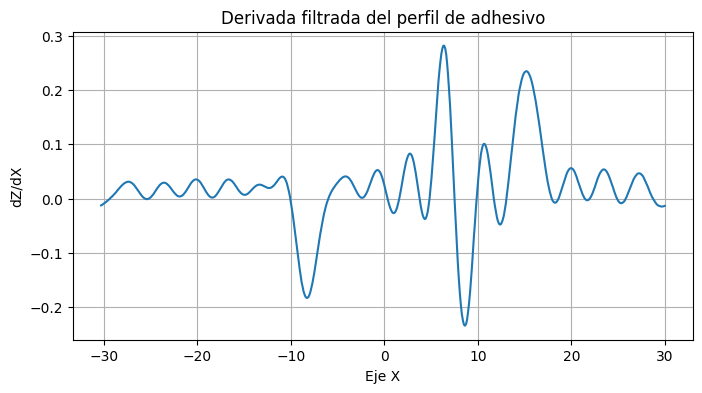

In [9]:
# Cálculo de Transformada rápida de Fourier
n = len(diffCoords[:, 0])
fhat = np.fft.fft(diffCoords[:, 1], n) # Cálculo de la transformada
powerSpectrum = fhat * np.conj(fhat) / n # Cálculo de la densidad espectral de potencia
L = np.arange(1,np.floor(n/2), dtype = np.int64) # Vector de muestras (Mitad de los valores)

# Uso de PSD para filtrar el ruido
UMBRAL_CORTE = 20
indices = np.arange(1,np.floor(n)+1, dtype = np.int64) < UMBRAL_CORTE # Indices de los valores que superan el umbral
PSDclean = powerSpectrum * indices # PSD filtrada
fhatFilt = indices * fhat # Transformada filtrada
zDifFilt = np.real(np.fft.ifft(fhatFilt)) # Transformada inversa

diffCoords = np.column_stack((coords[:-1, 0], np.real(zDifFilt)))
print(np.size(np.abs(diffCoords),axis=0))

# Visualización de la densidad espectral de potencia
plt.figure(figsize = (8, 4))
plt.stem(L, np.abs(powerSpectrum[L]))
plt.stem(L, np.abs(PSDclean[L]), 'r--')
plt.title("Densidad espectral de potencia")
plt.ylabel("Potencia")
plt.legend(["PSD", "PSD filtrada"])
plt.grid(True)

# Visualización de la derivada filtrada
plt.figure(figsize = (8, 4))
plt.plot(coords[:-1, 0], zDifFilt)
plt.title("Derivada filtrada del perfil de adhesivo")
plt.xlabel("Eje X")
plt.ylabel("dZ/dX")
plt.grid(True)

Minimos locales
[[-8.21897163 -0.18283742]
 [ 8.62102837 -0.2340829 ]]
Maximos locales
[[ 6.30102837  0.28158716]
 [15.18102837  0.2347356 ]]
Indice de inicio de pista
203
Indice de inicio de hilo
341
Indice de fin de hilo
363
Indice de fin de pista
425


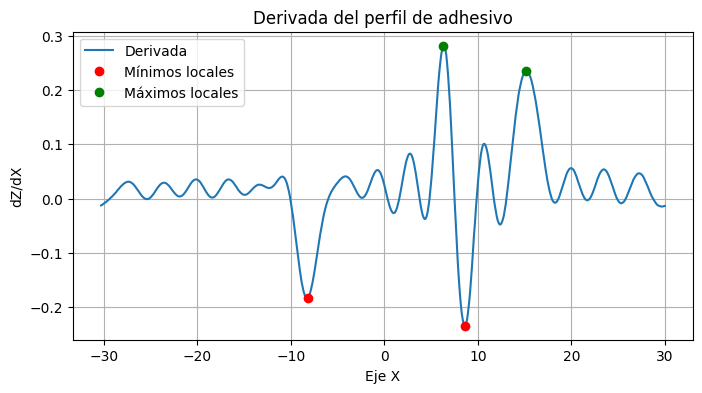

In [10]:
# Búsqueda de los máximos y mínimos locales
pksmin = argrelextrema(diffCoords[:,1], np.less)[0]
pksmax = argrelextrema(diffCoords[:,1], np.greater)[0]

# Búsqueda de máximos y mínimos globales (Detección de hilo)
idMax = np.argmax(diffCoords[pksmax,1])
idMin = np.argmin(diffCoords[pksmin,1])

maxGlobal = np.array([diffCoords[pksmax[idMax],0], diffCoords[pksmax[idMax],1], pksmax[idMax]])
minGlobal = np.array([diffCoords[pksmin[idMin],0], diffCoords[pksmin[idMin],1], pksmin[idMin]])

pksmin = np.delete(pksmin,idMin) # Se elimina de la lista para la búsqueda de los demás extremos
pksmax = np.delete(pksmax,idMax)

# Búsqueda de los máximos y mínimos locales
idMaxLoc = np.argmax(diffCoords[pksmax,1])
idMinLoc = np.argmin(diffCoords[pksmin,1])

maxLocal = np.array([diffCoords[pksmax[idMaxLoc],0], diffCoords[pksmax[idMaxLoc],1],pksmax[idMaxLoc]])
minLocal = np.array([diffCoords[pksmin[idMinLoc],0], diffCoords[pksmin[idMinLoc],1],pksmin[idMinLoc]])

minimum = np.array([minLocal, minGlobal])
maximum = np.array([maxGlobal, maxLocal])

print("Minimos locales") ; print(minimum[:,:-1])
print("Maximos locales") ; print(maximum[:,:-1])

# Tracking de pista e hilo
idInitPista = int(minimum[np.argmin(minimum[:,0]),2])
idEndPista = int(maximum[np.argmax(maximum[:,0]),2])
idInitHilo = int(maximum[np.argmin(maximum[:,0]),2])
idEndHilo = int(minimum[np.argmax(minimum[:,0]),2])
print("Indice de inicio de pista") ; print(idInitPista)
print("Indice de inicio de hilo"); print(idInitHilo)
print("Indice de fin de hilo") ; print(idEndHilo)
print("Indice de fin de pista") ; print(idEndPista)

plt.figure(figsize = (8, 4))
plt.plot(diffCoords[:, 0], diffCoords[:, 1])
plt.plot(minimum[:,0],minimum[:,1],'ro')
plt.plot(maximum[:,0],maximum[:,1],'go')
plt.title("Derivada del perfil de adhesivo")
plt.legend(["Derivada", "Mínimos locales", "Máximos locales"])
plt.xlabel("Eje X")
plt.ylabel("dZ/dX")
plt.grid(True)

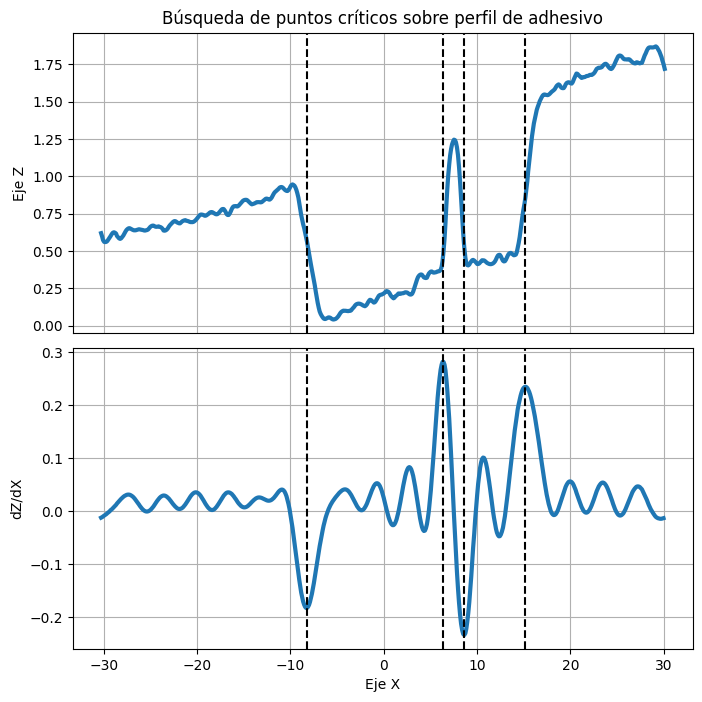

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Plot profile
ax1.plot(coords[:, 0], coords[:, 1], linewidth=3)
ax1.set_title("Búsqueda de puntos críticos sobre perfil de adhesivo")
ax1.set_ylabel("Eje Z")

ax1.grid(True)

# Plot derivative of profile
ax2.plot(diffCoords[:, 0], diffCoords[:, 1], linewidth=3)
ax2.set_xlabel("Eje X")
ax2.set_ylabel("dZ/dX")

# Draw vertical dashed lines from the black points
for point in minimum:
    ax1.axvline(x=point[0], color='k', linestyle='--')
    ax2.axvline(x=point[0], color='k', linestyle='--')

for point in maximum:
    ax1.axvline(x=point[0], color='k', linestyle='--')
    ax2.axvline(x=point[0], color='k', linestyle='--')

ax2.grid(True)

# Remove x-axis from the top plot
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.05)

plt.show()


## Paso 3. Análisis de componentes principales

Para esta operación se llevará a cabo una SVD (_Singular Value Decomposition_), la cual es un método de factorización matricial muy presente en todos los algoritmos de procesamiento de datos. Es usada para obtener aproximaciones óptimas de bajo orden de matrices y para llevar a cabo _pseudo-inversiones_ de matrices no cuadradas para encontrar soluciones a los sistemas $Ax = b$.

Este método numérico permite llevar a cabo una descomposición de una matriz con la siguiente estructura

$$X = U * S * V$$

Donde U es la proyección de los datos **normalizados** sobre el eje dominante, S es una matriz que contiene la dimensión de los datos, y es diagonal. Y V es una matriz de rotación. Entonces, para poder rotar los datos sobre el eje x, basta con hacer la siguiente operación

$$X_{proj}=U * S \hspace{1cm} o \hspace{1cm} X_{proj}=X * V$$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[ 0.9998375   0.01802702]
 [ 0.01802702 -0.9998375 ]]
[[ 0.9998375  -0.01802702]
 [-0.01802702  0.9998375 ]]


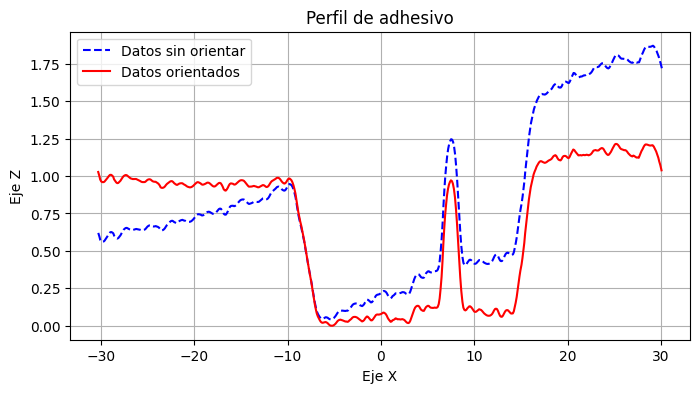

In [12]:
# Para orientar el perfil se empleará el tramo desde el inicio de la pista hasta el inicio del hilo, que es el tramo más recto del perfil
coordsSVD = coords[idInitPista:idInitHilo,:]

U, S, V = np.linalg.svd(coords,full_matrices=False)

print(V)
# Reconfiguración de PCA para que los datos queden correctamente orientados
mRot = np.abs(V)
mRot[0, 1] = -mRot[0, 1] # Para eliminar el efecto espejo
if V[1, 0] >= 0:
    mRot[1,0] = -mRot[1,0] # Para los perfiles con tendencia ascendente
print(mRot)

coordsPCA = np.dot(coords,mRot.T)

coordsPCA[:,1] = coordsPCA[:,1] - np.min(coordsPCA[:,1])

fig = plt.figure(figsize = (8, 4))
plt.plot(xRaw, zFilt,'b--')
plt.plot(coordsPCA[:, 0], coordsPCA[:, 1],'r')
plt.title("Perfil de adhesivo")
plt.xlabel("Eje X")
plt.ylabel("Eje Z") 
plt.legend(["Datos sin orientar", "Datos orientados"])
plt.grid(True)

## Paso 4. Clasificación de puntos del perfil

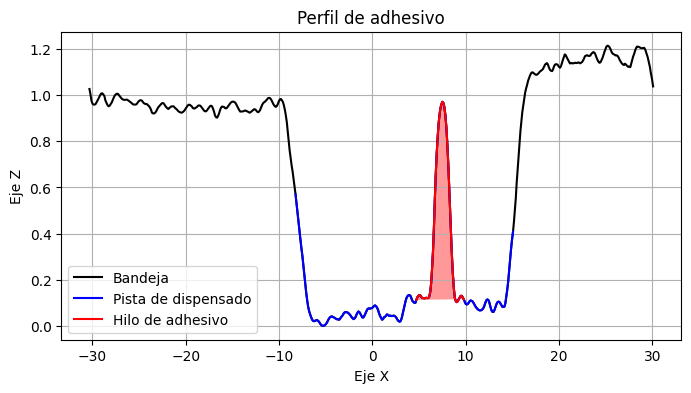

In [13]:
# Índices correspondientes a la pista de dispensado de adhesivo
# Primer mínimo a segundo máximo
idPista = np.arange(idInitPista, idEndPista)
#print(idPista)

# Índices correspondientes al hilo de adhesivo
# Ajuste fino de los índices del hilo de adhesivo

while not diffCoords[idInitHilo, 1] <= 0:
    idInitHilo -= 1

while not diffCoords[idEndHilo, 1] >= 0:
    idEndHilo += 1

# Primer máximo a segundo mínimo
idHilo = np.arange(idInitHilo, idEndHilo)

# Inicialmente todas las etiquetas son 0
labels = np.zeros(len(coordsPCA))

# Etiquetado de la pista de dispensado
labels[idPista] = 1

# Etiquetado del hilo de adhesivo
labels[idHilo] = 2

# Visualización de los datos
plt.figure(figsize = (8, 4))
#plt.scatter(coordsPCA[:, 0], coordsPCA[:, 1], c = labels)
plt.plot(coordsPCA[:, 0], coordsPCA[:, 1],'k')
plt.plot(coordsPCA[idPista, 0], coordsPCA[idPista, 1], 'b')
plt.plot(coordsPCA[idHilo, 0], coordsPCA[idHilo, 1], 'r')
plt.fill(coordsPCA[idHilo, 0], coordsPCA[idHilo, 1], 'r', alpha=0.4)
plt.title("Perfil de adhesivo")
plt.xlabel("Eje X")
plt.ylabel("Eje Z")
plt.grid(True)
plt.legend(["Bandeja", "Pista de dispensado", "Hilo de adhesivo"])
plt.show()

## Paso 5. Extracción de características

### Cálculo de sección del hilo de adhesivo
Una de las principales operaciones que se pueden hacer con los perfiles medidos por el sensor, es calcular secciones. Para ello la principal herramienta es la integración.

Sabiendo que el sensor emite una nube de puntos, la única forma plausible de obtener la sección del objeto detectado es mediante una integración numérica. En este caso, se empleará la integral trapezoidal compleja, ya que emplear recursos de computación en el uso de métodos numéricos más complejos como la regla de Simpson no tendría sentido.

La regla trapezoidal lleva a cabo una interpolación polinomial de grado 1 en dos nodos $x_0=a$ y $x_1=b$. Esta integral se hará en todos los pares de puntos que se han etiquetado dentro de lo que se considera como "hilo de adhesivo", las áreas se sumarán, y así se obtendrá el valor deseado.

<center><img src="./FigurasJupyter/reglaTrapezoidalCompleja.png" width="700px"/></center>

Siendo la integral numérica igual a la siguiente expresión:

$$\int_{a}^{b}f(x)dx \approx \frac{b-a}{2n}\left[f(a)+2\sum_{j=1}^{n-1}{f(x_j)}+f(b)\right]$$

In [14]:
# Cálculo del área de la sección transversal
integral = abs(trapz(coordsPCA[idHilo, 0], coordsPCA[idHilo, 1]))
print(f"Área: {integral:.3f} mm^2")

Área: 1.345 mm^2


/var/folders/qq/59l8jfj10bb6776hrk9cypv80000gn/T/ipykernel_27955/1827519939.py:2: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  integral = abs(trapz(coordsPCA[idHilo, 0], coordsPCA[idHilo, 1]))


### Cálculo de posición relativa del hilo en la pista
Este cálculo es simplemente obtener la diferencia entre la posición en el eje x del inicio de la pista de dispensado, y un punto significativo del hilo de adhesivo (en este caso se escogió la mediana de dicho conjunto de datos).

In [15]:
# Tracking del hilo respecto al inicio de la pista de dispensado
is_empty = np.size(idHilo) == 0
posHilo = 0
if is_empty:
    posHilo = -1
else:
    index = int(np.ceil(np.median(idHilo)))
    posHilo = coordsPCA[index,0] - coordsPCA[idPista[0],0]
print(f"Posición del hilo: {posHilo:.3f} mm")

Posición del hilo: 15.416 mm
